# **Object Detection and Image Segmentation task**

## **Object Detection**

In [ ]:
# download yolov3 weights
!wget https://pjreddie.com/media/files/yolov3.weights

In [33]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/Corso_ML/object detection/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import required packages
import cv2
import argparse
import numpy as np

In [4]:
def get_output_layers(net):
    layer_names = net.getLayerNames()
    try:
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    except:
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [43]:
# read input image
image = cv2.imread(path+'dog.jpg')

Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

# read class names from text file
classes = None
with open(path+'yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
weights = '/content/yolov3.weights'
config =  path+'yolov3.cfg'
print(weights)
net = cv2.dnn.readNet(weights, config)

# create input blob
blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

# set input blob for the network
net.setInput(blob)

/content/yolov3.weights


In [44]:
outs = net.forward(get_output_layers(net))

class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4


for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])


indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

for i in indices:
    try:
        box = boxes[i]
    except:
        i = i[0]
        box = boxes[i]

    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))


cv2.imwrite("object-detection.jpg", image)

True

## **Image segmentation**

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()


In [46]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)


In [47]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms

# filename = path+'img3.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)


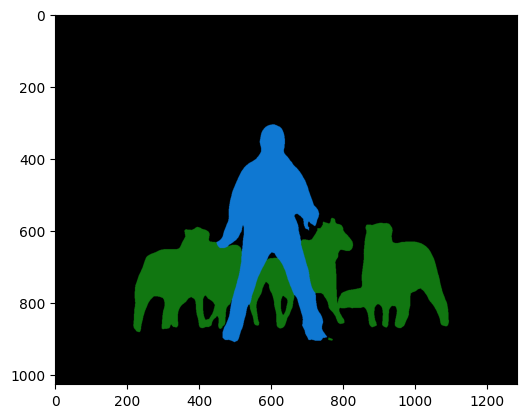

In [50]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)

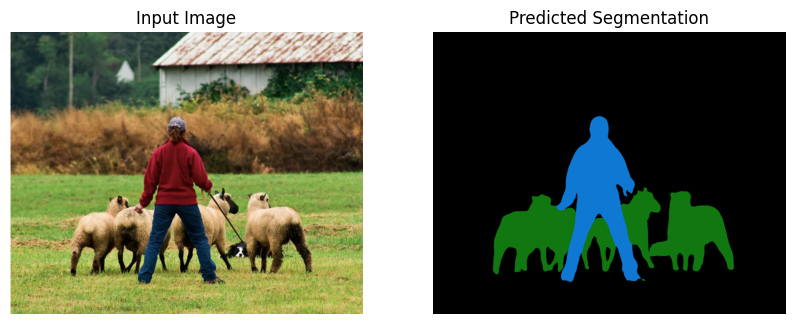

In [49]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(r, cmap='viridis')
plt.title('Predicted Segmentation')
plt.axis('off')

plt.show()